# Training an image classifier from scratch on the Kaggle Trash Images dataset.

### Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import keras_cv
import numpy as np

### Data Load and Cleanup

Delete any image that is corrupted and does not contain "JFIF" header

In [2]:
num_skipped = 0

waste_classes = ["cardboard",
                 "glass",
                 "metal",
                 "paper",
                 "plastic",
                 "trash"]

for folder_name in waste_classes:
    folder_path = os.path.join("..", "data", "trash_images", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


### Configure Hyper Parameters

In [11]:
num_epochs = 1
image_size = (180, 180)
batch_size = 128

### Dataset Generation

Using batch size of 128 and image size of 180x180

In [4]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/trash_images",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Using 505 files for validation.


### Visualizing some of the data

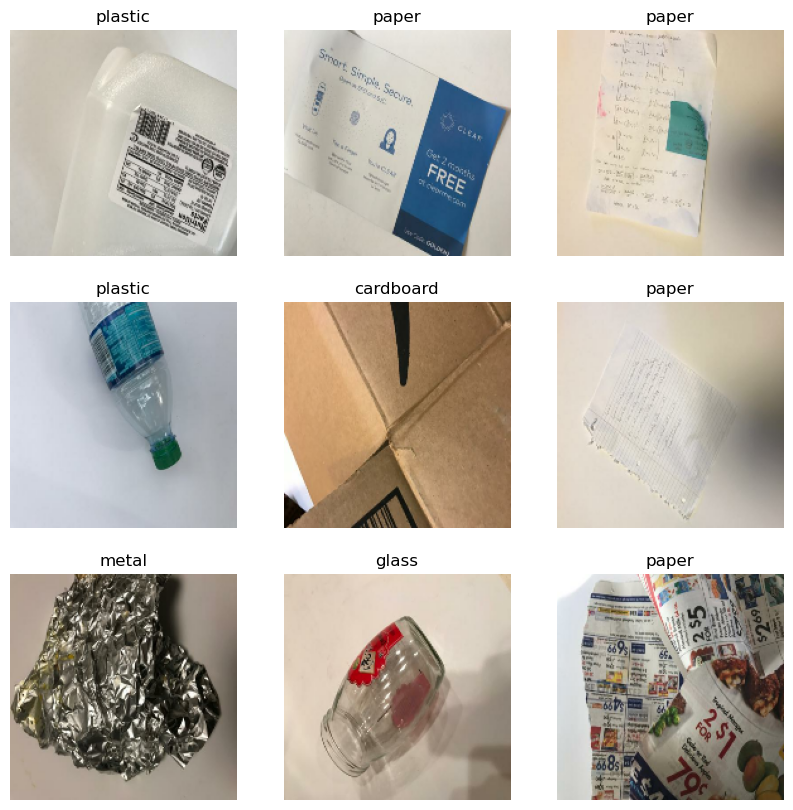

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(waste_classes[labels[i]])
        plt.axis("off")

### Augmenting dataset

Artificially inducing sample diversity by applying transformations to training images. <br>
We apply random flips and rotations to help expose the model to different aspects of training data.

In [6]:
data_augmentation_layers = [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandAugment(
            value_range=(0, 255),
            augmentations_per_image=2,
            magnitude=0.5,
            magnitude_stddev=0.15,
        ),
    ]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

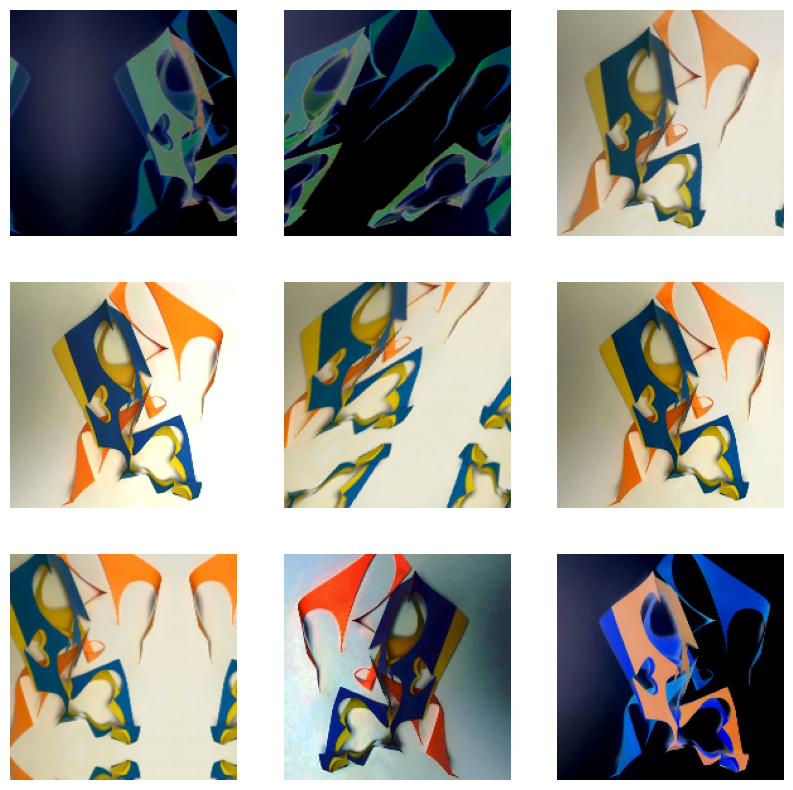

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

### Synchronous Pre-Processing of Images

Attempting to pre-fetch images and apply data augmentation to training data

In [8]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### Model Construction

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


### Model Training

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=num_epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

model.save(f"model_{num_epochs}_epochs.keras")

16/16 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.1724 - loss: -2.2539 - val_accuracy: 0.1489 - val_loss: 36.6484


### Testing with an image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
This image is 124.21% cardboard and -24.21% glass and -24.21% metal and -24.21% paper and -24.21% plastic and -24.21% trash.


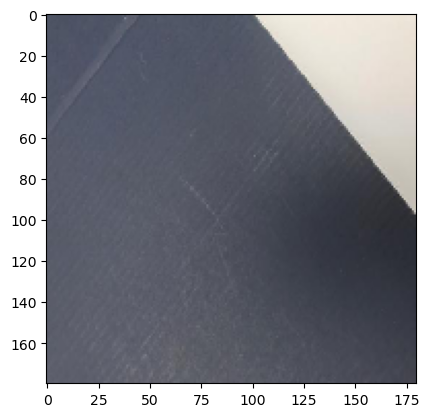

In [13]:
img = keras.utils.load_img("../data/trash_images/cardboard/cardboard_015.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])

# Define the materials as list
materials = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Generating the message
output_strings = [f"{100 * (1 - score):.2f}% {material}" if material == "cardboard" 
                  else f"{100 * score:.2f}% {material}" for material in materials]

# Join and print
output = " and ".join(output_strings)
print(f"This image is {output}.")


In [ ]:
score

-0.030964655801653862